In [64]:
import tensorflow as tf
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
!pip install -q addict

In [67]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# Functions

In [68]:
def seed_everything(seed:int=42) -> None:
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [69]:
def get_optimizer(model:torch.nn.Module, name:str="SGD", parameters:dict={}) -> torch.optim.Optimizer:
    optimizers = {
        "SGD": torch.optim.SGD,
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "RMSprop": torch.optim.RMSprop,
    }

    instance = optimizers.get(name, "SGD")
    optimizer = instance(model.parameters(), **parameters)

    return optimizer

In [70]:
def get_scheduler(optimizer:torch.optim.Optimizer, name:str, parameters:dict):
    schedulers = {
        "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "LambdaLR": torch.optim.lr_scheduler.LambdaLR,
        "StepLR": torch.optim.lr_scheduler.StepLR,
        "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR,
        "MultiplicativeLR": torch.optim.lr_scheduler.MultiplicativeLR,
        "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR,
    }

    instance = schedulers[name]
    scheduler = instance(optimizer, **parameters)

    return scheduler

In [71]:
def accuracy_score(predictions:torch.Tensor, targets:torch.Tensor) -> torch.Tensor:
    amount = (predictions == targets).sum()
    accuracy = amount / targets.size(0)

    return accuracy

In [72]:
def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)

In [73]:
def plot_images(rows, cols, indexes, class_=0):
    min_index = min(indexes)
    max_index = max(indexes)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i in range(*indexes):
        item = train_dataset[i]
        image = item.image
        label = item.label

        if label == class_:
            ax = fig.add_subplot(rows, cols, (i - min_index)+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
    fig.show()

In [74]:
def get_logger(name:str=__name__, format:str="[%(asctime)s][%(levelname)s]: %(message)s") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(format)

    file_handler = logging.FileHandler(name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    logger.propagate = False

    return logger

# Configs

In [75]:
config = Dict({
    "train_path": "/content/drive/MyDrive/Train_dataset/Train",
    "test_path": "/content/drive/MyDrive/Test/Test",
    "validation_path": "/content/drive/MyDrive/Validation/Validation"
})

for path_name, path in config.items():
    class_counts = {}
    for class_name in ["Healthy", "Powdery", "Rust"]:
        class_path = os.path.join(path, class_name)
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

    print(f"Image counts in {path_name}:")
    for class_name, count in class_counts.items():
        print(f"- {class_name}: {count}")

Image counts in train_path:
- Healthy: 180
- Powdery: 180
- Rust: 180
Image counts in test_path:
- Healthy: 60
- Powdery: 60
- Rust: 60
Image counts in validation_path:
- Healthy: 60
- Powdery: 60
- Rust: 60


In [78]:
train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 10,
    "seed": 2021,
    "image_shape": (128, 128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

# Data Preprocessing

In [79]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations

        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass

        else:
            pass

    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        loader = A.Compose([
            A.Resize(width=width, height=height),
            ToTensorV2(),
        ])

        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]
    def __len__(self):
        return len(self.__images_labels)

    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path)

        if self.augmentations is not None:
            image = image.permute(1, 2, 0).numpy()
            image = self.augmentations(image=image)["image"]

        label = self.labels.index(label)

        return Dict({
            "image": image,
            "label": label,
        })
def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label

        all_images.append(item.image.tolist())
        all_labels.append(label)

    return {
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }


In [80]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

<ipython-input-90-d0fb9bc5e633>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)


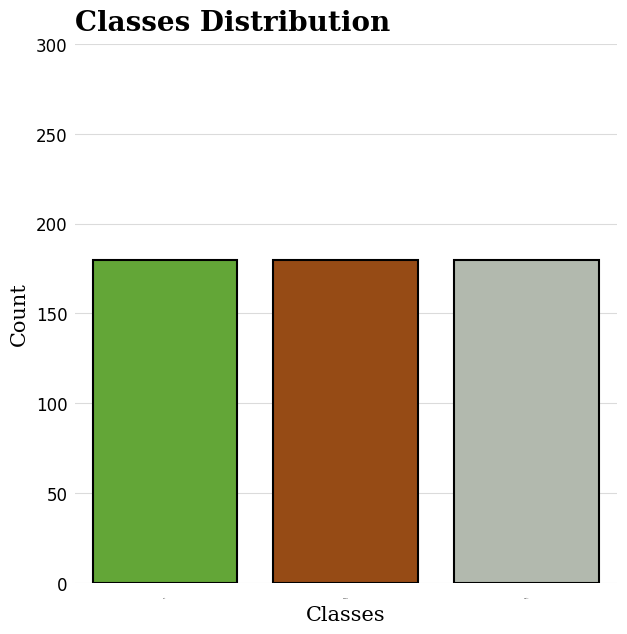

In [90]:
label_pathes = [os.path.join(config.train_path, label) for label in train_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=1, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 350 , 50)))
ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)
hide_spines(ax)
fig.show()

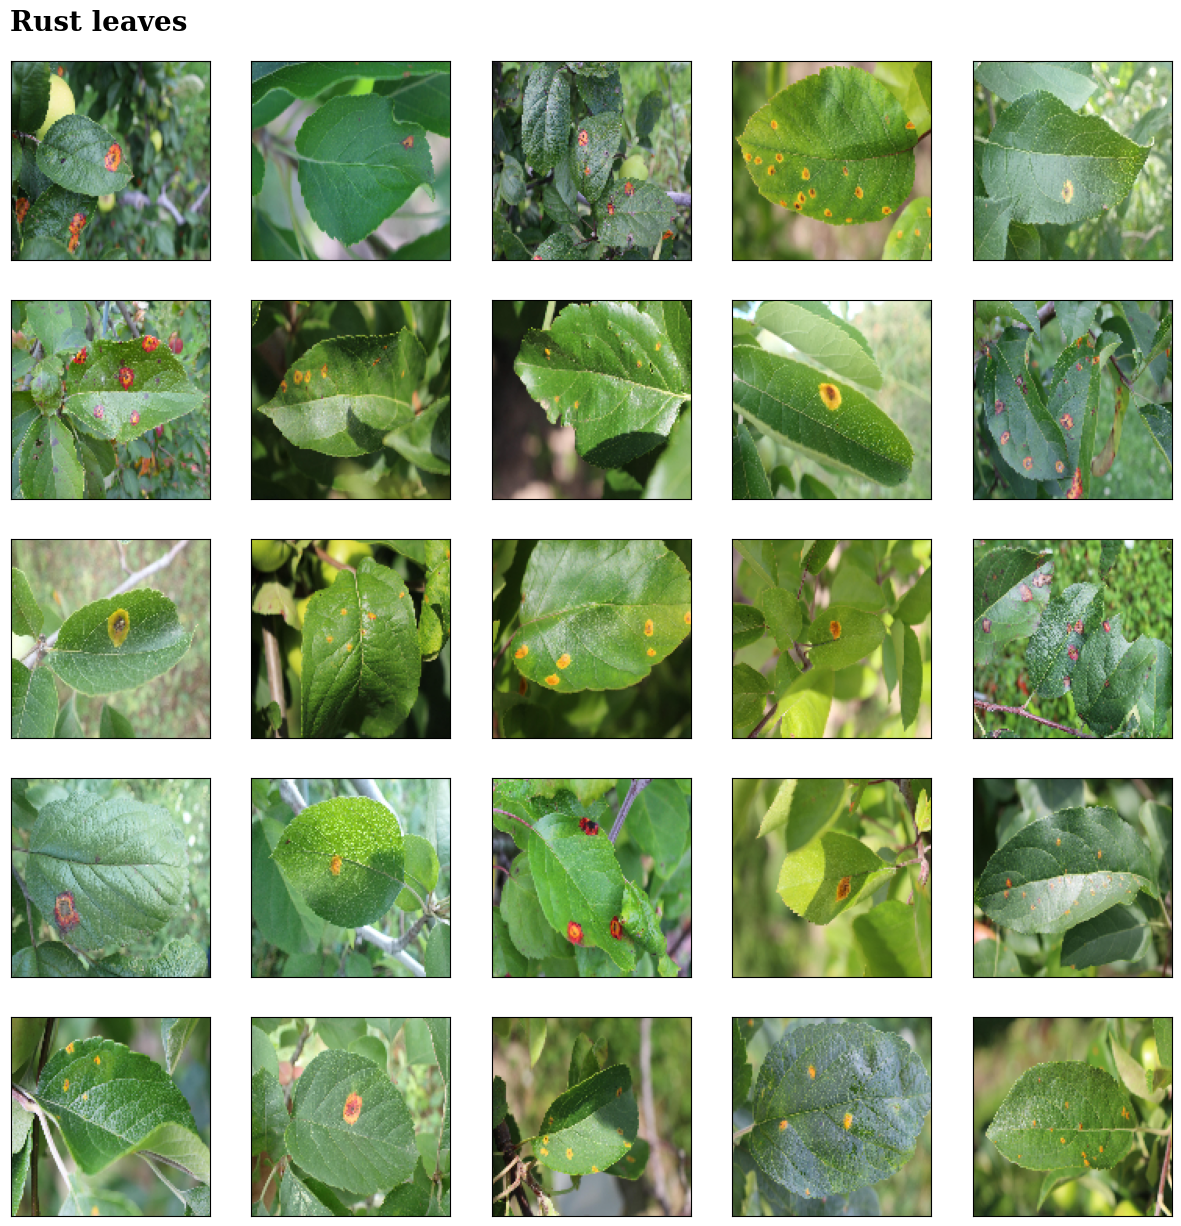

In [91]:
plot_images(rows=5, cols=5, indexes=(0, 25), class_=0)

In [92]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path,
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape,
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path,
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape,
                                   channels=train_config.image_channels)

In [93]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True,
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=train_config.batch_size*2,
                               num_workers=train_config.num_workers,
                               pin_memory=True,
                               shuffle=False,
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False,
                         collate_fn=collate_fn)

# Modelling

In [94]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes=2):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.resnet34(pretrained=True)

        for parameter in self.model.parameters():
            parameter.requires_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )

    def forward(self, image):
        output = self.model(image)
        return output

In [95]:
class Trainer:
    def __init__(self, model, criterion, optimizer,  metric, scheduler=None, logger=None, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.logger = logger
        self.device = torch.device(device)
        self.best_validation_loss = 0
        self.metric = metric
        self.history = Dict({})

    def __log(self, logs):
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []

            self.history[k].append(v)
    def evaluate(self, loader):
        loss, score, length = 0, 0, len(loader)

        self.model.to(self.device)
        with torch.no_grad():
            loop = tqdm(loader, position=0, colour="BLACK", desc=f"Evaluating: ", leave=True)
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.model.eval()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                loss += batch_loss.item()
                batch_score = self.metric(predictions, labels).item()
                score += batch_score

            loss /= length
            score /= length

        return loss, score



    def fit(self, train_loader, validation_loader=None, epochs=10):
        self.model.to(self.device)
        train_length = len(train_loader)

        for epoch in range(epochs):
            epoch_loss, epoch_score = 0, 0

            loop = tqdm(train_loader, position=0, colour="BLACK", leave=True, desc=f"Epoch [{epoch+1}/{epochs}]: ")
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                self.model.train()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                epoch_loss += batch_loss.item()

                batch_score = self.metric(predictions, labels).item()
                epoch_score += batch_score

                batch_loss.backward()
                self.optimizer.step()

            epoch_loss /= train_length
            epoch_score /= train_length
            self.__log({"train_losses": epoch_loss, "train_scores": epoch_score})
            if self.logger is not None: self.logger.info(f"Epoch [{epoch+1}/{epochs}]: Loss: {epoch_loss} | Accuracy_score: {epoch_score}")

            if validation_loader is not None:
                validation_loss, validation_score = self.evaluate(validation_loader)
                self.__log({"validation_losses": validation_loss, "validation_scores": validation_score})
                if self.logger is not None: self.logger.info(f"Validation Epoch [{epoch+1}/{epochs}]: Loss: {validation_loss} | Accuracy_score: {validation_score}")



                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(validation_loss)
                    else:
                        self.scheduler.step()

                    if self.logger is not None:
                        lr = self.optimizer.param_groups[0]["lr"]
                        self.logger.info(f"Epoch [{epoch+1}/{epochs}] Learning Rate: {lr}")

In [96]:
model = PlantDiseaseModel(classes=len(train_dataset.labels))
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model=model,
                          name=train_config.optimizer.type,
                          parameters=train_config.optimizer.parameters)

if "scheduler" in train_config:
    scheduler = get_scheduler(optimizer=optimizer,
                              name=train_config.scheduler.type,
                              parameters=train_config.scheduler.parameters)

trainer_logger = get_logger("trainer")
trainer = Trainer(model=model,
                  criterion=criterion,
                  metric=accuracy_score,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  logger=trainer_logger,
                  device=train_config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
trainer.fit(train_loader=train_loader, validation_loader=validation_loader, epochs=train_config.epochs)

Epoch [1/10]: 100%|██████████| 17/17 [01:20<00:00,  4.74s/it]
[2024-01-21 15:25:04,054][INFO]: Epoch [1/10]: Loss: 1.030956019373501 | Accuracy_score: 0.5178571431075826
[2024-01-21 15:25:04,054][INFO]: Epoch [1/10]: Loss: 1.030956019373501 | Accuracy_score: 0.5178571431075826
Evaluating: 100%|██████████| 3/3 [00:24<00:00,  8.22s/it]
[2024-01-21 15:25:28,738][INFO]: Validation Epoch [1/10]: Loss: 1.0841712951660156 | Accuracy_score: 0.3649839758872986
[2024-01-21 15:25:28,738][INFO]: Validation Epoch [1/10]: Loss: 1.0841712951660156 | Accuracy_score: 0.3649839758872986
[2024-01-21 15:25:28,741][INFO]: Epoch [1/10] Learning Rate: 0.001
[2024-01-21 15:25:28,741][INFO]: Epoch [1/10] Learning Rate: 0.001
Epoch [2/10]: 100%|██████████| 17/17 [01:14<00:00,  4.38s/it]
[2024-01-21 15:26:43,187][INFO]: Epoch [2/10]: Loss: 0.8857987382832695 | Accuracy_score: 0.7665441176470589
[2024-01-21 15:26:43,187][INFO]: Epoch [2/10]: Loss: 0.8857987382832695 | Accuracy_score: 0.7665441176470589
Evaluating

# Try with Another Model

In [103]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes=2):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.densenet121(pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, classes)

    def forward(self, image):
        output = self.model(image)
        return output

In [104]:
class Trainer:
    def __init__(self, model, criterion, optimizer,  metric, scheduler=None, logger=None, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.logger = logger
        self.device = torch.device(device)
        self.best_validation_loss = 0
        self.metric = metric
        self.history = Dict({})

    def __log(self, logs):
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []

            self.history[k].append(v)
    def evaluate(self, loader):
        loss, score, length = 0, 0, len(loader)

        self.model.to(self.device)
        with torch.no_grad():
            loop = tqdm(loader, position=0, colour="BLACK", desc=f"Evaluating: ", leave=True)
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.model.eval()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                loss += batch_loss.item()
                batch_score = self.metric(predictions, labels).item()
                score += batch_score

            loss /= length
            score /= length

        return loss, score



    def fit(self, train_loader, validation_loader=None, epochs=10):
        self.model.to(self.device)
        train_length = len(train_loader)

        for epoch in range(epochs):
            epoch_loss, epoch_score = 0, 0

            loop = tqdm(train_loader, position=0, colour="BLACK", leave=True, desc=f"Epoch [{epoch+1}/{epochs}]: ")
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                self.model.train()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                epoch_loss += batch_loss.item()

                batch_score = self.metric(predictions, labels).item()
                epoch_score += batch_score

                batch_loss.backward()
                self.optimizer.step()

            epoch_loss /= train_length
            epoch_score /= train_length
            self.__log({"train_losses": epoch_loss, "train_scores": epoch_score})
            if self.logger is not None: self.logger.info(f"Epoch [{epoch+1}/{epochs}]: Loss: {epoch_loss} | Accuracy_score: {epoch_score}")

            if validation_loader is not None:
                validation_loss, validation_score = self.evaluate(validation_loader)
                self.__log({"validation_losses": validation_loss, "validation_scores": validation_score})
                if self.logger is not None: self.logger.info(f"Validation Epoch [{epoch+1}/{epochs}]: Loss: {validation_loss} | Accuracy_score: {validation_score}")



                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(validation_loss)
                    else:
                        self.scheduler.step()

                    if self.logger is not None:
                        lr = self.optimizer.param_groups[0]["lr"]
                        self.logger.info(f"Epoch [{epoch+1}/{epochs}] Learning Rate: {lr}")

In [116]:
model = PlantDiseaseModel(classes=len(train_dataset.labels))
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model=model, name=train_config.optimizer.type, parameters=train_config.optimizer.parameters)

if "scheduler" in train_config:
    scheduler = get_scheduler(optimizer=optimizer, name=train_config.scheduler.type, parameters=train_config.scheduler.parameters)
else:
    scheduler = None

trainer_logger = get_logger("trainer")
trainer = Trainer(model=model, criterion=criterion, metric=accuracy_score,
                  optimizer=optimizer, scheduler=scheduler, logger=trainer_logger, device=train_config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.2MB/s]


In [117]:
trainer.fit(train_loader=train_loader, validation_loader=validation_loader, epochs=train_config.epochs)

Epoch [1/10]: 100%|██████████| 17/17 [01:24<00:00,  4.95s/it]
[2024-01-21 16:09:18,431][INFO]: Epoch [1/10]: Loss: 0.3030781578820418 | Accuracy_score: 0.8889180672268907
[2024-01-21 16:09:18,431][INFO]: Epoch [1/10]: Loss: 0.3030781578820418 | Accuracy_score: 0.8889180672268907
[2024-01-21 16:09:18,431][INFO]: Epoch [1/10]: Loss: 0.3030781578820418 | Accuracy_score: 0.8889180672268907
Evaluating: 100%|██████████| 3/3 [00:31<00:00, 10.37s/it]
[2024-01-21 16:09:49,566][INFO]: Validation Epoch [1/10]: Loss: 8.114254196484884 | Accuracy_score: 0.32411858974358976
[2024-01-21 16:09:49,566][INFO]: Validation Epoch [1/10]: Loss: 8.114254196484884 | Accuracy_score: 0.32411858974358976
[2024-01-21 16:09:49,566][INFO]: Validation Epoch [1/10]: Loss: 8.114254196484884 | Accuracy_score: 0.32411858974358976
[2024-01-21 16:09:49,571][INFO]: Epoch [1/10] Learning Rate: 0.001
[2024-01-21 16:09:49,571][INFO]: Epoch [1/10] Learning Rate: 0.001
[2024-01-21 16:09:49,571][INFO]: Epoch [1/10] Learning Rate

# Testing

In [118]:
def test_model(model, criterion, loader, device):
    model.eval()
    total_loss, total_score, total_length = 0, 0, 0

    with torch.no_grad():
        for batch in loader:
            images = batch["images"].float().to(device)
            labels = batch["labels"].long().to("cpu")

            probabilities = model(images).float().to("cpu")
            predictions = torch.argmax(probabilities, dim=1).detach()

            batch_loss = criterion(probabilities, labels)
            total_loss += batch_loss.item()

            batch_score = accuracy_score(predictions, labels).item()
            total_score += batch_score

            total_length += 1

    average_loss = total_loss / total_length
    average_score = total_score / total_length

    return average_loss, average_score

# Test the model on the test dataset
test_loss, test_accuracy = test_model(trainer.model, nn.CrossEntropyLoss(), test_loader, device=train_config.device)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 6.571980148553848
Test Accuracy: 0.3685897435897436


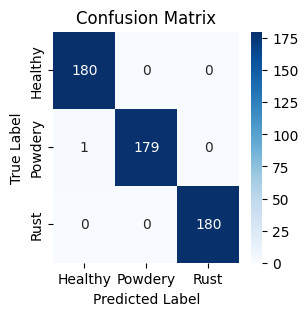

In [119]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            images = batch["images"].float().to(device)
            labels = batch["labels"].long().to("cpu")

            probabilities = model(images).float().to("cpu")
            predictions = torch.argmax(probabilities, dim=1).detach()

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ["Healthy", "Powdery","Rust"]
plot_confusion_matrix(trainer.model, train_loader, device=train_config.device, class_names=class_names)

In [120]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_metrics(model, loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            images = batch["images"].float().to(device)
            labels = batch["labels"].long().to("cpu")

            probabilities = model(images).float().to("cpu")
            predictions = torch.argmax(probabilities, dim=1).detach()

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    # Get the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the numerical values of the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate and display classification metrics
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision_macro = precision_score(y_true, y_pred, average='macro') * 100
    recall_macro = recall_score(y_true, y_pred, average='macro') * 100
    f1_macro = f1_score(y_true, y_pred, average='macro') * 100

    print('Accuracy Score:', accuracy, '%')
    print('Precision Macro Score:', precision_macro, '%')
    print('Recall Score:', recall_macro, '%')
    print('F1 Score:', f1_macro, '%')

evaluate_classification_metrics(trainer.model, train_loader, device=train_config.device, class_names=class_names)

Confusion Matrix:
[[180   0   0]
 [  2 178   0]
 [  0   0 180]]
Accuracy Score: 99.62962962962963 %
Precision Macro Score: 99.63369963369964 %
Recall Score: 99.62962962962963 %
F1 Score: 99.62961819809254 %


# Save Model

In [129]:
model = trainer.model
torch.save(model, 'densenet121_model.pt')

# Load Model

In [130]:
Load_model = torch.load('/content/densenet121_model.pt', map_location=torch.device('cpu'))

In [ ]:
print(Load_model )

# Prediction with unseen images

In [132]:
import cv2
import numpy as np
import torch

# Load and preprocess the new image
image_path = "/content/images (8).jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # If your model expects RGB
image = cv2.resize(image, (256, 256))  # Adjust the size as needed
image = image / 255.0  # Normalize the pixel values

# Load the model
model = torch.load('/content/densenet121_model.pt', map_location=torch.device('cpu'))
model.eval()
# Convert the image to a PyTorch tensor
image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)

# Add batch dimension (if needed)
image_tensor = image_tensor.unsqueeze(0)

# Make the prediction
with torch.no_grad():
    output = model(image_tensor)

# Convert the output to probabilities using softmax
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the predicted class index
predicted_class = torch.argmax(probabilities).item()

In [133]:
# Assuming you have a dictionary mapping class indices to labels
class_index_to_label = {0: 'Healthy', 1: 'Powdery',2: 'Rust'}

# Get the label for the predicted class
predicted_label = class_index_to_label[predicted_class]

print(f"Predicted Label: {predicted_label}")

Predicted Label: Healthy


In [136]:
print("Raw Output Probabilities:", output[0].tolist())
print("Predicted Class Index:", predicted_class)
class_index_to_label = {0: 'Healthy', 1: 'Powdery',2: 'Rust'}
predicted_label = class_index_to_label[predicted_class]
print(f"Predicted Label: {predicted_label}")

Raw Output Probabilities: [1.0473777055740356, -0.864351749420166, -0.43045759201049805]
Predicted Class Index: 0
Predicted Label: Healthy
